Limpeza: Removendo espaços, identificadores (Flow ID, Timestamp, Umma,ed: 0) e colunas vazias...
Pré-processamento: Convertendo infinitos e preenchendo valores nulos...
Target: Processando coluna 'Label' como Binário (0=Normal, 1=Attack)...
Seleção de Features: Iniciando pipeline de redução de dimensionalidade...

--- Iniciando Processo de Seleção de Features (Total: 83) ---
Variância: 16 features removidas. Restantes: 67
Correlação (>0.95): 34 features redundantes removidas. Restantes: 33
Random Forest: Pular.
Features Finais (33) - ['Source Port_Entropy', 'Destination Port_Entropy', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Bytes/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Mean', 'Bwd IAT Mean', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length', 'Bwd Header Length', 'Bwd Packe

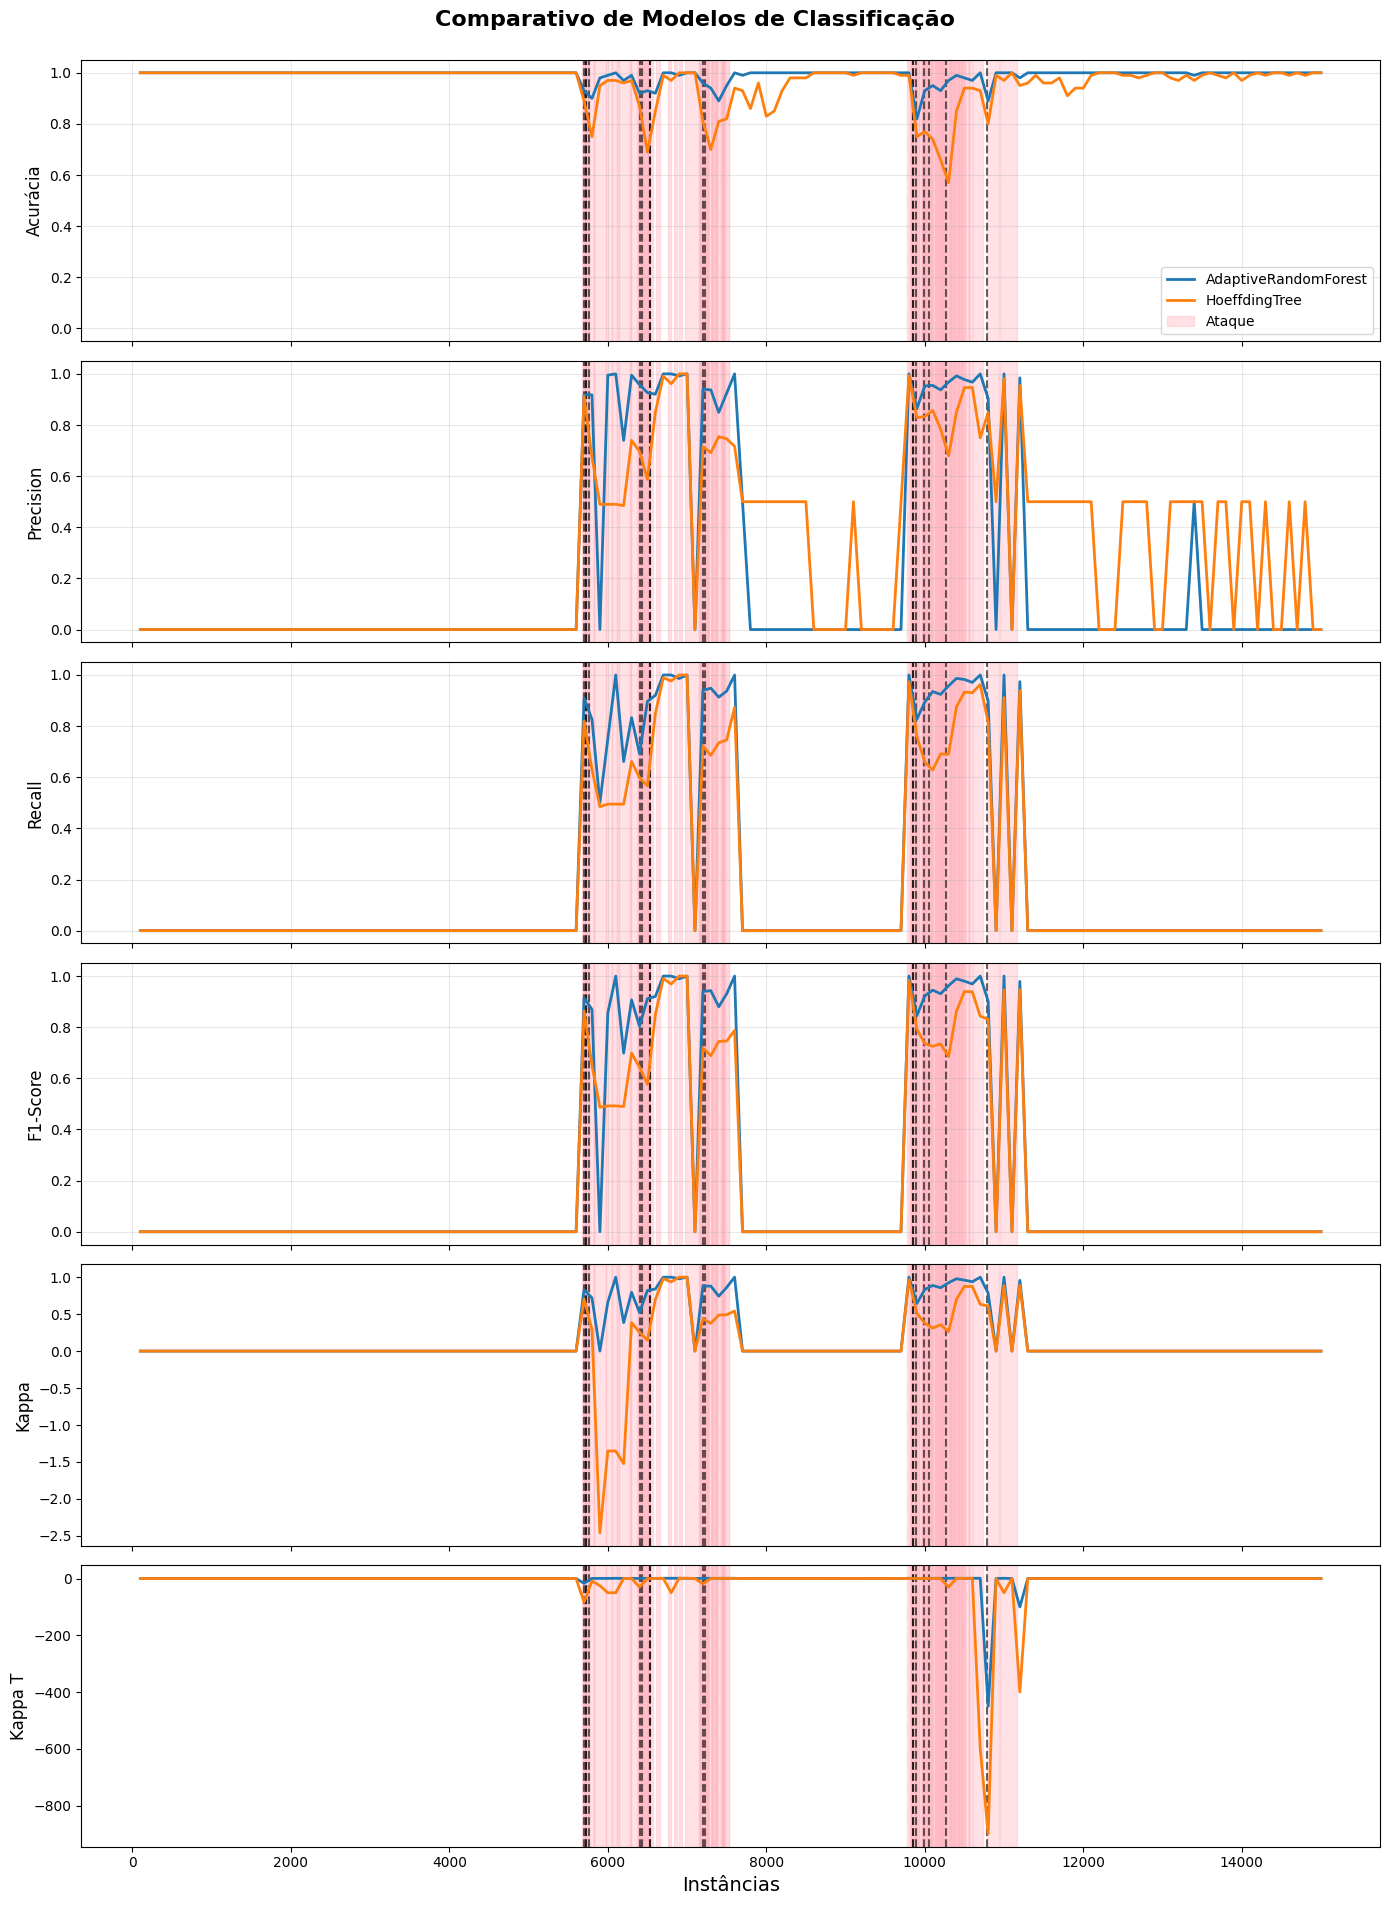

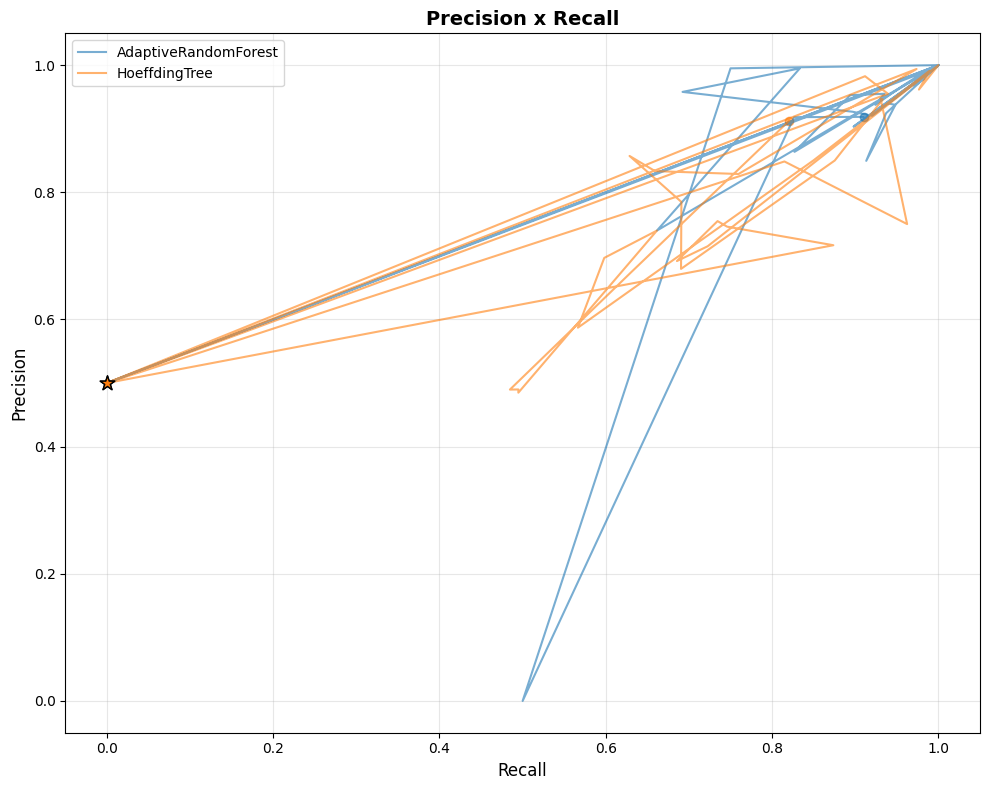

In [1]:
from py.ClassificationModels import get_classification_models
from py.ClassificationPipeline import ClassificationExperimentRunner
from py.Streams import newStream
import pandas as pd

INICIO = 0
FIM = 15000
TOTAL_AMOSTRAS = FIM - INICIO
MAX_INSTANCES = TOTAL_AMOSTRAS

df = pd.read_csv(
    'datasets/CICDDoS2019/data/Exp_janela/SNMP_DNS_1s_0112.csv', 
    skiprows=range(1, INICIO), 
    nrows=TOTAL_AMOSTRAS
)

stream, target_names, feature_names = newStream(
    df=df, 
    target_label_col='Label', 
    binary_label=True, 
    normalize_method="MinMaxScaler", 
    threshold_var=0.75,
    threshold_corr=0.95,
    top_n_features=None,
    stream=True
)

# Configurar Stream
schema = stream.get_schema()

# Obter modelos
modelos = get_classification_models(schema, selected_models=['ARF', 'HT'])

# Instanciar e Executar
runner = ClassificationExperimentRunner()

resultados = runner.pipeline(
    stream=stream,
    models=modelos,
    window_size=100,
    logging=False,
    title="Comparativo de Modelos de Classificação"
)

Limpeza: Removendo espaços, identificadores (Flow ID, Timestamp, Umma,ed: 0) e colunas vazias...
Pré-processamento: Convertendo infinitos e preenchendo valores nulos...
Target: Processando coluna 'Label' como Binário (0=Normal, 1=Attack)...
Seleção de Features: Iniciando pipeline de redução de dimensionalidade...

--- Iniciando Processo de Seleção de Features (Total: 83) ---
Variância: 16 features removidas. Restantes: 67
Correlação (>0.95): 33 features redundantes removidas. Restantes: 34
Random Forest: Pular.
Features Finais (34) - ['Source Port_Entropy', 'Destination Port_Entropy', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Bytes/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Mean', 'Bwd IAT Mean', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length', 'Bwd Header Length', 'Bwd Packe

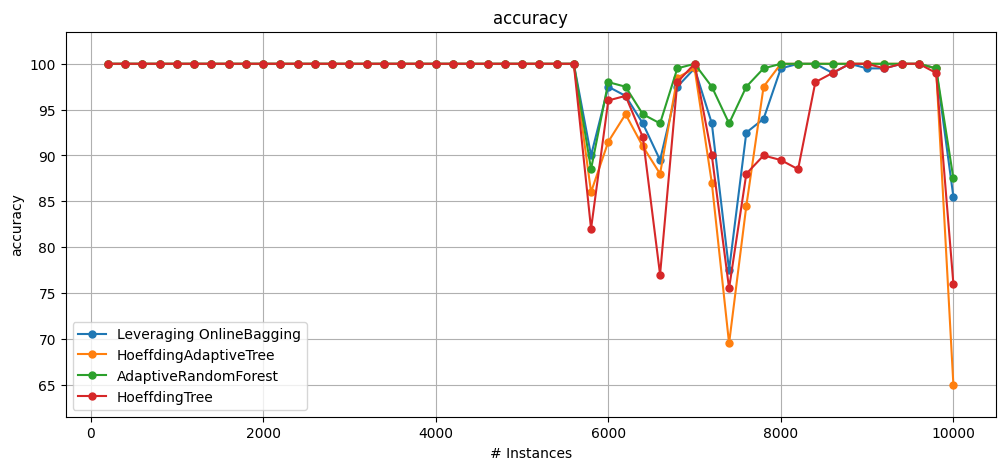

In [10]:
from capymoa.evaluation import prequential_evaluation_multiple_learners
from capymoa.evaluation.visualization import plot_windowed_results
from py.ClassificationModels import get_classification_models
from py.Streams import newStream
import pandas as pd

INICIO = 0
FIM = 10000
TOTAL_AMOSTRAS = FIM - INICIO
MAX_INSTANCES = TOTAL_AMOSTRAS

df = pd.read_csv(
    'datasets/CICDDoS2019/data/Exp_janela/SNMP_DNS_1s_0112.csv', 
    skiprows=range(1, INICIO), 
    nrows=TOTAL_AMOSTRAS
)

stream, target_names, feature_names = newStream(
    df=df, 
    target_label_col='Label', 
    binary_label=True, 
    normalize_method="MinMaxScaler", 
    threshold_var=0.75,
    threshold_corr=0.95,
    top_n_features=None,
    stream=True
)

# Configurar Stream
schema = stream.get_schema()

# Obter modelos
modelos = get_classification_models(schema, selected_models=['LB', 'HAT', 'ARF', 'HT'])

# Executar avaliação prequential
results = prequential_evaluation_multiple_learners(stream, modelos, window_size=200, max_instances=len(df))

# Exibir resultados
if 'LeveragingBagging' in results:
    print(f"LB accuracy = {results['LeveragingBagging'].cumulative.accuracy()}")

if 'HoeffdingAdaptiveTree' in results:
    print(f"HAT accuracy = {results['HoeffdingAdaptiveTree'].cumulative.accuracy()}")

if 'AdaptiveRandomForest' in results:
    print(f"ARF accuracy = {results['AdaptiveRandomForest'].cumulative.accuracy()}")

if 'HoeffdingTree' in results:
    print(f"HT accuracy = {results['HoeffdingTree'].cumulative.accuracy()}")

plot_windowed_results(*results.values(), metric="accuracy", save_only=False)